### **Aluna**: Lais de Souza Ziegler
# 🛳️ Predição de sobrevivência em naufrágio no Mediterrâneo
Dataset: treino.csv

O projeto de predição de sobrevivência em naufrágios utiliza um conjunto de dados inspirado em um incidente recente no Mediterrâneo, contendo informações sobre 7.124 passageiros a bordo de um navio. As variáveis incluem identificação única do passageiro, nome, informações da cabine (deck, número e posição), procedência, destino, idade, status de VIP, modalidade de hospedagem e gastos com serviços a bordo. O objetivo é prever a probabilidade de um passageiro sobreviver ao naufrágio com base em suas características.

### 1️⃣ Leitura e exploração dos dados
---
#### Importando as bibliotecas necessárias para a análise de dados

In [164]:
# Pacotes básicos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Pacotes do Scikit-learn para modelagem, avaliação e preparação
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, f1_score, roc_curve,
                             roc_auc_score, precision_score, ConfusionMatrixDisplay)
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

# Pacotes para modelos de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [165]:
# Função para avaliar métricas dos modelos
def evaluate_model(y_test, y_pred, y_prob):
    print(f"Acurácia no conjunto de teste: {accuracy_score(y_test, y_pred)* 100:.2f}%")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"Precisão: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.2f}")

# Função para exibir a matriz de confusão
def exibir_matriz_confusao(y_true, y_pred):
    print("Matriz de Confusão:")
    resultado = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(resultado)
    cm_display.plot(cmap="Purples")
    fig = cm_display.figure_
    fig.set_figheight(3)
    fig.set_figwidth(3)
    plt.show()

#### Carregando o conjunto de dados a partir de um arquivo CSV
- Em seguida, imprimindo os tipos de dados de cada coluna para entender a estrutura do DataFrame

In [166]:
df = pd.read_csv("treino.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7124 entries, 0 to 7123
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   IDpassageiro   7124 non-null   object 
 1   Nome           7124 non-null   object 
 2   Deck           7124 non-null   object 
 3   NumeroCabine   7124 non-null   int64  
 4   PosicaoCabine  7124 non-null   object 
 5   Procedencia    7124 non-null   object 
 6   Destino        7124 non-null   object 
 7   Idade          7124 non-null   float64
 8   VIP            7124 non-null   int64  
 9   AllInclusive   7124 non-null   int64  
 10  ServicoCabine  7124 non-null   float64
 11  Restaurante    7124 non-null   float64
 12  Shopping       7124 non-null   float64
 13  SPA            7124 non-null   float64
 14  ParquedeAguas  7124 non-null   float64
 15  Sobrevivente   7124 non-null   int64  
dtypes: float64(6), int64(4), object(6)
memory usage: 890.6+ KB


#### Exibindo as primeiras cinco linhas do conjunto de dados para uma visão geral dos dados


In [167]:
df.head()

,IDpassageiro,Nome,Deck,NumeroCabine,PosicaoCabine,Procedencia,Destino,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente
0,5647_02,Chabih Matoltuble,C,178,P,America,Monaco,52.0,0,0,0.0,1425.0,31.0,0.0,1320.0,1
1,0107_01,Coobix Hart,D,2,S,Africa,Grecia,21.0,0,0,1743.0,5.0,17.0,0.0,0.0,0
2,4158_01,Doryn Noeley,E,273,S,Europa,Grecia,27.0,0,0,0.0,0.0,580.0,211.0,0.0,0
3,1316_01,Sadrus Quelfly,E,95,S,America,Grecia,28.0,0,1,0.0,0.0,0.0,0.0,0.0,1
4,9069_05,Mirfark Taketiatim,B,297,P,America,Monaco,29.0,0,0,0.0,12563.0,0.0,3.0,5057.0,0


#### Exibindo um resumo estatístico das colunas numéricas do DataFrame

In [168]:
df.describe()

,NumeroCabine,Idade,VIP,AllInclusive,ServicoCabine,Restaurante,Shopping,SPA,ParquedeAguas,Sobrevivente
count,7124.000000,7124.000000,7124.000000,7124.000000,7124.00000,7124.000000,7124.00000,7124.000000,7124.000000,7124.000000
mean,603.314570,28.709714,0.023582,0.350225,211.90539,451.186272,164.56050,296.767827,302.433605,0.506457
std,514.229314,14.480996,0.151754,0.477074,618.42357,1604.170133,540.36276,1104.861331,1146.269782,0.499993
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,169.000000,19.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,430.000000,27.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000
75%,1000.000000,37.000000,0.000000,1.000000,38.00000,64.000000,21.25000,54.000000,41.000000,1.000000
max,1894.000000,79.000000,1.000000,1.000000,9920.00000,29813.000000,12253.00000,22408.000000,20336.000000,1.000000


### Visualizar a proporção de sobreviventes na coluna Sobrevivente do dataset
Gráfico de pizza com proporções:
- Roxo: Sobreviventes.
- Amarelo: Não sobreviventes.

Proporção entre sobreviventes e vítimas é claramente visualizada. Isso nos ajuda a identificar possíveis tendências de desequilíbrio no dataset.
- O dataset possui um equilíbrio relativo entre sobreviventes e não sobreviventes, o que é favorável para treinar modelos de aprendizado supervisionado.
- A pequena diferença sugere que balanceamento adicional pode não ser necessário neste atributo.

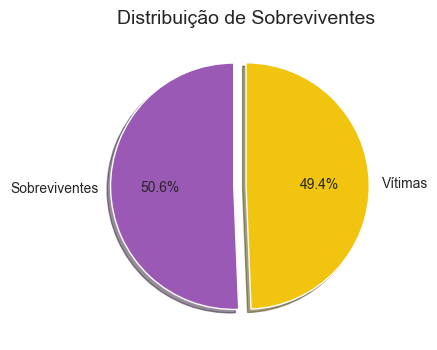

In [169]:
total_true = df['Sobrevivente'].sum()
total_false = len(df['Sobrevivente']) - total_true

labels = ['Sobreviventes', 'Vítimas']
sizes = [total_true, total_false]
colors = ['#9B59B6', '#F1C40F']
explode = (0.1, 0)

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode, shadow=True)

plt.title('Distribuição de Sobreviventes', fontsize=14)
plt.show()

## Análise de Passageiros em Família e Solo
Identificar se os passageiros se estão viajando sozinhos ou em grupo (família) com base em um identificador fornecido.

- Separar o ID de Grupo e o Número do Integrante
    - Dividimos o identificador único de cada passageiro (`IDpassageiro`) em duas partes: o grupo ao qual o passageiro pertence e o número de cada integrante dentro desse grupo. Isso nos permite rastrear quantos passageiros fazem parte de cada grupo.

- Identificar se o Passageiro está em Família
    - Com a contagem de passageiros por grupo, criou-se uma nova coluna ("EmGrupo") para os passageiros que pertencem a grupos com mais de um integrante
    - É possível ver que mais de 59% dos passageiros estão sozinhos, e quase 41% estão em Grupo ou Família.


In [170]:
df[['Grupo', 'Integrante']] = df['IDpassageiro'].str.split('_', expand=True)
group_counts = df['Grupo'].value_counts()
df['EmGrupo'] = df['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

print(df.EmGrupo.value_counts())

EmGrupo
0    4240
1    2884
Name: count, dtype: int64


#### Visualização dos Tamanhos dos Grupos
- Criar um dataframe para contar os tamanhos dos grupos, levando em conta apenas aqueles "grupos" com mais de 1 integrante.
- Exibir em um gráfico de Tamanho dos grupos e Quantidade de Grupos

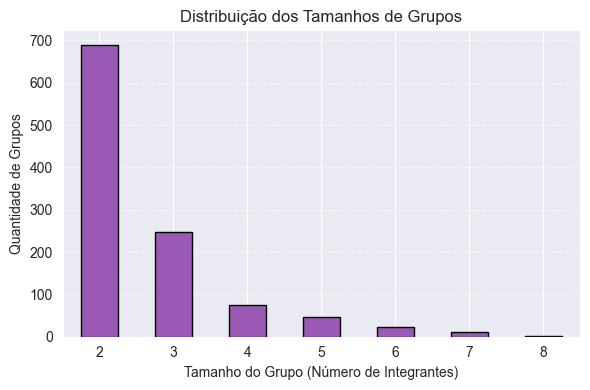

In [171]:
group_size_counts = group_counts.value_counts().sort_index()
filtered_group_size_counts = group_size_counts[group_size_counts.index > 1]

plt.figure(figsize=(6, 4))
filtered_group_size_counts.plot(kind='bar', color='#9B59B6', edgecolor='black')

plt.title('Distribuição dos Tamanhos de Grupos')
plt.xlabel('Tamanho do Grupo (Número de Integrantes)')
plt.ylabel('Quantidade de Grupos')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Visualizar a Distribuição de Passageiros por Deck
Mostrando visualmente a quantidade de passageiros em cada Deck do navio.

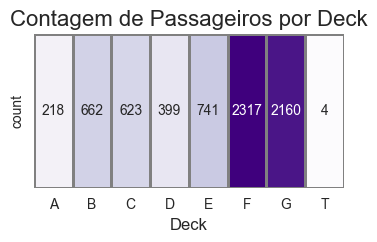

In [172]:
deck_counts = df['Deck'].value_counts().reset_index()
deck_counts_sorted = deck_counts.sort_values(by='Deck', ascending=True)
deck_counts.columns = ['Deck', 'Contagem']

plt.figure(figsize=(4, 2))
sns.heatmap(deck_counts_sorted.set_index('Deck').T, annot=True, fmt='d', cmap='Purples', cbar=False, linewidths=1, linecolor='gray')

plt.title('Contagem de Passageiros por Deck', fontsize=16)
plt.xlabel('Deck', fontsize=12)
plt.show()

### Visualizar a Distribuição de Passageiros por Deck e Posição da Cabine
Mostrando visualmente a proporção de sobreviventes em cada Cabine e Deck do navio.

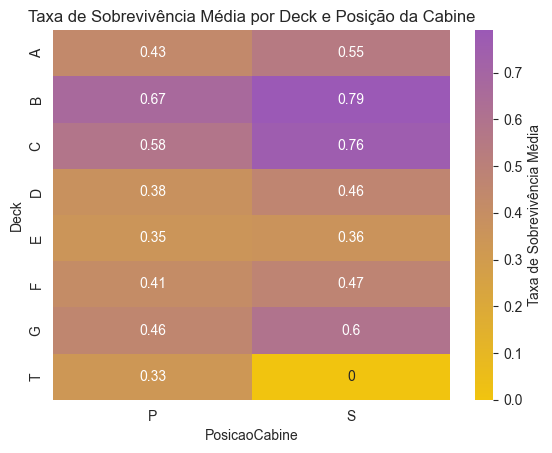

In [173]:
pivot_table = df.pivot_table(values="Sobrevivente", index="Deck", columns="PosicaoCabine", aggfunc="mean")
colors = ['#F1C40F', '#9B59B6']
cmap = LinearSegmentedColormap.from_list("purple_yellow", colors)
sns.heatmap(pivot_table, annot=True, cmap=cmap, cbar_kws={'label': 'Taxa de Sobrevivência Média'})
plt.title("Taxa de Sobrevivência Média por Deck e Posição da Cabine")
plt.show()

### Análise das Faixas Etárias e Taxa de Sobrevivência:
- **Criação de novas colunas**
   - `GrupoHetario` foi criado para agrupar idade em faixas.

In [174]:
df['GrupoHetario'] = pd.cut(df['Idade'], bins=[-1, 17, 35, 59, 100], labels=["Crianças", "Jovens", "Adultos", "Idosos"])

#### Calcula a média da taxa de sobrevivência para cada grupo etário presente no conjunto de dados.

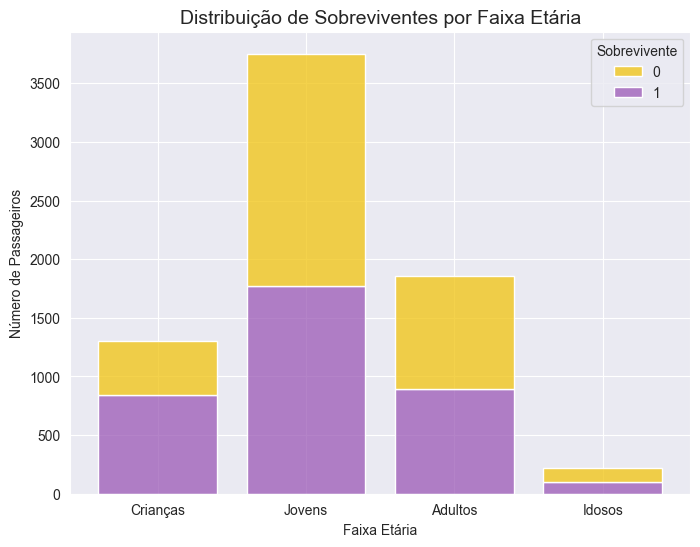

  Faixa Etária  Taxa de Sobrevivência
0     Crianças               0.645385
1       Jovens               0.472422
2      Adultos               0.481402
3       Idosos               0.476852


In [175]:
survival_by_age_group = df.groupby('GrupoHetario', observed=False)['Sobrevivente'].mean()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='GrupoHetario', hue='Sobrevivente', multiple='stack', palette=colors, shrink=0.8)
plt.title('Distribuição de Sobreviventes por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária')
plt.ylabel('Número de Passageiros')
plt.show()

survival_table = survival_by_age_group.reset_index()
survival_table.columns = ['Faixa Etária', 'Taxa de Sobrevivência']
print(survival_table)

### 2️⃣ Transformação e Pré-processamento de dados
---
- **Cálculo do Total Gasto:**
  - Cria uma nova coluna chamada 'TotalGasto', que é a soma das colunas relacionadas a serviços consumidos pelos passageiros: 'ServicoCabine', 'Restaurante', 'Shopping', 'SPA', e 'ParquedeAguas'.

- **Codificação de Variáveis Categóricas:**
  - Utiliza o `OrdinalEncoder` para transformar variáveis categóricas em valores numéricos, aplicando a codificação para todas as colunas do tipo `object`.

- **Exclusão de Colunas Irrelevantes:**
  - Remove colunas que não são necessárias para a análise ou modelagem, como informações de identificação e outros atributos irrelevantes.

- **Resultado Final:**
  - O DataFrame resultante contém apenas as colunas numéricas e as variáveis codificadas, prontas para análise ou modelagem.


In [176]:
df['TotalGasto'] = df[['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas']].sum(axis=1)


ordinal_encoder = OrdinalEncoder()
df[df.select_dtypes(include=['object']).columns] = ordinal_encoder.fit_transform(
    df.select_dtypes(include=['object'])
)

df.drop(['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas', 'IDpassageiro', 'Nome', 'NumeroCabine', 'Grupo', 'Integrante', 'GrupoHetario'], axis=1, inplace=True)

#### Análise de Correlação
  - Utiliza o método `.corr()` para calcular a matriz de correlação entre todas as colunas numéricas do DataFrame.

A análise ajuda a entender quais variáveis têm maior correlação entre si, facilitando a seleção de features para modelos preditivos.


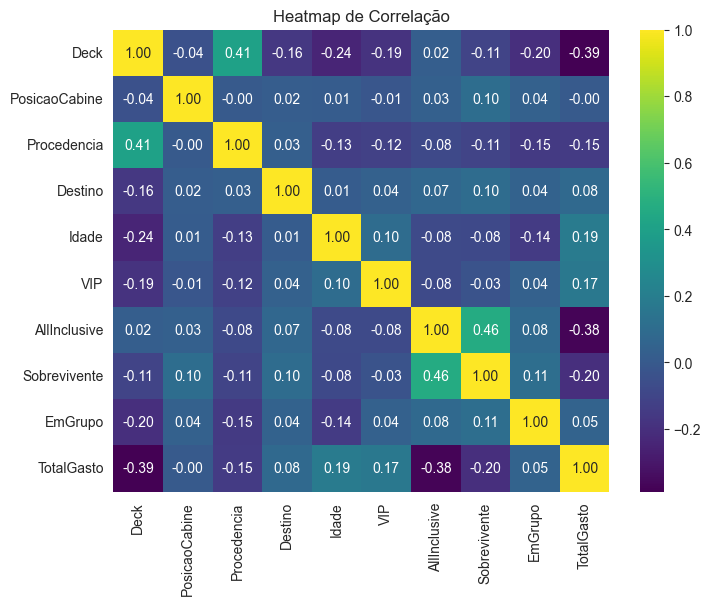

In [177]:
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=True
)
plt.title("Heatmap de Correlação")
plt.show()

### 3️⃣ Modelos

#### Separando os atributos do conjunto de dados em variáveis independentes (X) e a variável dependente (y).
- As variáveis independentes são todas as colunas do DataFrame, exceto 'Sobrevivente', que é removida.
- A variável dependente 'Sobrevivente' é isolada em y.

#### Dividir os dados em conjuntos de treinamento e teste

In [178]:
X = df.drop(["Sobrevivente"], axis=1)
y = df["Sobrevivente"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modelo 1: KNN

- **Configuração:** Testa diferentes valores de `n_vizinhos` (1 a 15) e usa validação cruzada com 10 divisões (`k_splits`).
- **Busca de Parâmetros:** Utiliza `GridSearchCV` para explorar combinações de `n_neighbors` e `weights` (uniforme ou distância).
- **Resultados:** Exibe a melhor configuração de parâmetros (número de vizinhos e peso) com a maior acurácia média.

In [179]:
n_vizinhos = [1, 3, 5, 7, 9, 11, 13, 14, 15]
k_splits = 10

parametros = { 'n_neighbors': n_vizinhos, 'weights':['uniform', 'distance']}
modelo_knn = KNeighborsClassifier()
valcruz = GridSearchCV(modelo_knn, parametros,cv=k_splits)
valcruz.fit(X_train, y_train)
resultados = pd.DataFrame(valcruz.cv_results_).sort_values(by='rank_test_score')

print('Melhor resultado - Número vizinhos:{}   Pesos:{}    Acurácia média:{:.3f}'.format(
    resultados['param_n_neighbors'].iloc[0],
    resultados['param_weights'].iloc[0],
    resultados['mean_test_score'].iloc[0]))

Melhor resultado - Número vizinhos:14   Pesos:uniform    Acurácia média:0.732


#### Protocolo Experimental com Preparação e Modelagem

- **Configuração do Pipeline**
- **Busca de Parâmetros com GridSearchCV**
- **Exibição dos Resultados**

In [180]:
modelo_knn = Pipeline(steps=[
    ('reescala', MinMaxScaler()),
     ('modelagem', KNeighborsClassifier())
    ])

parametros = {'modelagem__n_neighbors':n_vizinhos, 'modelagem__weights':['uniform', 'distance']}
kfold = KFold(n_splits=k_splits, shuffle=True, random_state=0)
grade = GridSearchCV(modelo_knn, param_grid=parametros, cv=kfold)
grade.fit(X_train,y_train)

print('Melhor k:{}  score:{:0.3f}'.format(grade.best_params_, grade.best_score_))

Melhor k:{'modelagem__n_neighbors': 14, 'modelagem__weights': 'uniform'}  score:0.721


#### Captura da Melhor Configuração e Avaliação do Modelo
- **Treinamento e Resultados:** Treina o modelo com os melhores parâmetros encontrados, exibe a acurácia obtida e avalia o desempenho no conjunto de teste.

C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Acurácia no conjunto de teste: 72.64%
F1 Score: 0.70
Precisão: 0.79
Recall: 0.63
ROC AUC: 0.74
Matriz de Confusão:


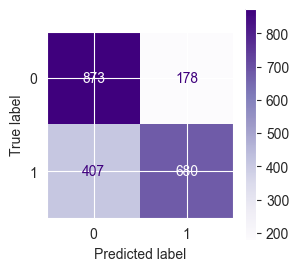

In [181]:
n_neighbors_best = grade.best_params_['modelagem__n_neighbors']
n_weights_best = grade.best_params_['modelagem__weights']

escalonador_knn = MinMaxScaler()
modelo_knn = KNeighborsClassifier(n_neighbors=n_neighbors_best, weights=n_weights_best)

treino_X_escalonado = escalonador_knn.fit_transform(X_train, y_train)
knn_teste_X_escalonado = escalonador_knn.transform(X_test)
modelo_knn.fit(treino_X_escalonado, y_train)

treino_pred_y = modelo_knn.predict(treino_X_escalonado)
knn_teste_pred_y = modelo_knn.predict(knn_teste_X_escalonado)

evaluate_model(y_test, knn_teste_pred_y, modelo_knn.predict_proba(X_test)[:,1])
exibir_matriz_confusao(y_test, knn_teste_pred_y)

## Modelo 2: XGBoost com RandomizedSearchCV

- **Definição do Modelo:** Utiliza o `XGBClassifier` com `random_state=42` para reprodutibilidade.

- **Busca de Hiperparâmetros:** Aplica o `RandomizedSearchCV` para otimizar os parâmetros do modelo, com 50 tentativas (`n_iter=50`) e validação cruzada de 3 divisões (`cv=3`).

- **Treinamento e Resultados:** Treina o modelo com os melhores parâmetros encontrados, exibe a acurácia obtida e avalia o desempenho no conjunto de teste.

In [182]:
modelo_xgboost = XGBClassifier(random_state=42)
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

random_search = RandomizedSearchCV(estimator=modelo_xgboost, param_distributions=param_dist,
                                   n_iter=50, scoring='accuracy', cv=3, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("Melhor acurácia:", random_search.best_score_)

best_model = random_search.best_estimator_
acc_test_best_model = best_model.score(X_test, y_test)

print(f"Acurácia no conjunto de teste com o melhor modelo: {acc_test_best_model * 100:.2f}%")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Melhores parâmetros encontrados:
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Melhor acurácia: 0.7470918572001605
Acurácia no conjunto de teste com o melhor modelo: 74.51%


#### Captura da Melhor Configuração e Avaliação do Modelo
- **Treinamento e Resultados:** Treina o modelo com os melhores parâmetros encontrados, exibe a acurácia obtida e avalia o desempenho no conjunto de teste.

Acurácia no conjunto de teste: 74.51%
F1 Score: 0.73
Precisão: 0.80
Recall: 0.66
ROC AUC: 0.78
Matriz de Confusão:


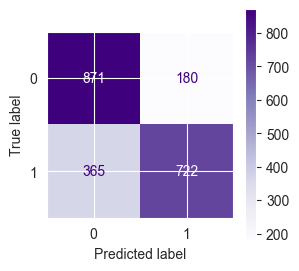

In [183]:
escalonador_xg = MinMaxScaler()
modelo_xgboost = XGBClassifier(gamma= 0, colsample_bytree= 0.8, max_depth=7,
                               learning_rate=0.05, n_estimators=100, random_state=42,
                               reg_alpha=1, reg_lambda=1, subsample= 0.8)

treino_X_escalonado = escalonador_xg.fit_transform(X_train, y_train)
xg_teste_X_escalonado = escalonador_xg.transform(X_test)
modelo_xgboost.fit(treino_X_escalonado, y_train)

treino_pred_y = modelo_knn.predict(treino_X_escalonado)
xg_teste_pred_y = modelo_xgboost.predict(xg_teste_X_escalonado)

evaluate_model(y_test, xg_teste_pred_y, modelo_xgboost.predict_proba(X_test)[:, 1])
exibir_matriz_confusao(y_test, xg_teste_pred_y)

## Modelo 3: Decision Tree com Validação Cruzada

**Configuração de Pipeline**
**Avaliação de Hiperparâmetros:**
   - `ccp_alpha`: Regularização para poda.
   - `max_leaf_nodes`: Número máximo de folhas.
   - `criterion`: Critério de divisão (`gini` ou `entropy`).
   - `feature_range`: Intervalo de reescalonamento.

**Validação Cruzada**
**Treinamento:**
   - Ajusta os dados ao pipeline e avalia diferentes combinações.
   - Listagem de melhores resultados de parâmetros


In [184]:
ccp_alphas = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
max_leafs = [2, 3, 4, 5, 6, 7, 8, 9]

k_splits = 10

modelo_dt = Pipeline(steps=[('reescala', MinMaxScaler()),
    ('modelo', DecisionTreeClassifier(random_state=0))])

parametros = {'reescala__feature_range':[(0,1)],
              'modelo__ccp_alpha': ccp_alphas,
              'modelo__max_leaf_nodes':max_leafs,
              'modelo__criterion':['gini','entropy']}

skfold = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=0)

valcruz = GridSearchCV(modelo_dt, parametros,cv=skfold)

valcruz.fit(X_train, y_train)

resultados = pd.DataFrame(valcruz.cv_results_).sort_values(by='rank_test_score')
melhor_feature_range = resultados['param_reescala__feature_range'].iloc[0]
melhor_criterion = resultados['param_modelo__criterion'].iloc[0]
melhor_max_leaf_nodes = resultados['param_modelo__max_leaf_nodes'].iloc[0]
melhor_ccp_alpha = resultados['param_modelo__ccp_alpha'].iloc[0]

print('Melhor preparação - Feature Range:{}'.format(melhor_feature_range))
print('Melhor resultado - Critério:{}   Máximo número de nodos folha:{}   Alfa:{}    Acurácia média:{:.3f}'.format(
    melhor_criterion,
    melhor_max_leaf_nodes,
    melhor_ccp_alpha,
    resultados['mean_test_score'].iloc[0]))


Melhor preparação - Feature Range:(0, 1)
Melhor resultado - Critério:entropy   Máximo número de nodos folha:9   Alfa:0.0    Acurácia média:0.742


#### Captura da Melhor Configuração e Avaliação do Modelo
- **Treinamento e Resultados:** Treina o modelo com os melhores parâmetros encontrados, exibe a acurácia obtida e avalia o desempenho no conjunto de teste.

Acurácia no conjunto de teste: 72.83%
F1 Score: 0.71
Precisão: 0.78
Recall: 0.65
ROC AUC: 0.74
Matriz de Confusão:


C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


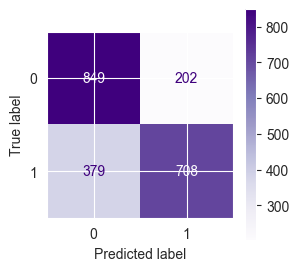

In [185]:
escalonador_dt = MinMaxScaler(feature_range = melhor_feature_range)
modelo_dt = DecisionTreeClassifier(ccp_alpha = melhor_ccp_alpha,
                                   max_leaf_nodes = melhor_max_leaf_nodes,
                                   criterion = melhor_criterion)

treino_X_escalonado = escalonador_dt.fit_transform(X_train, y_train)
modelo_dt.fit(treino_X_escalonado, y_train)
dt_teste_X_escalonado = escalonador_dt.transform(X_test)

dt_teste_pred_y = modelo_dt.predict(dt_teste_X_escalonado)
treino_pred_y = modelo_dt.predict(treino_X_escalonado)

evaluate_model(y_test, dt_teste_pred_y, modelo_dt.predict_proba(X_test)[:, 1])
exibir_matriz_confusao(y_test, dt_teste_pred_y)

#### Apresentação do modelo
- Exporta a estrutura da árvore de decisão treinada em formato de texto legível usando `export_text`.
- Exibe as divisões e regras baseadas nas features do conjunto de dados.


In [186]:
modelo_txt = export_text(modelo_dt, feature_names=list(X.columns))
print(modelo_txt)

|--- TotalGasto <= 0.00
|   |--- Procedencia <= 0.50
|   |   |--- AllInclusive <= 0.50
|   |   |   |--- Idade <= 0.16
|   |   |   |   |--- class: 1
|   |   |   |--- Idade >  0.16
|   |   |   |   |--- class: 1
|   |   |--- AllInclusive >  0.50
|   |   |   |--- Procedencia <= 0.17
|   |   |   |   |--- Deck <= 0.64
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Deck >  0.64
|   |   |   |   |   |--- class: 1
|   |   |   |--- Procedencia >  0.17
|   |   |   |   |--- Idade <= 0.04
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Idade >  0.04
|   |   |   |   |   |--- class: 1
|   |--- Procedencia >  0.50
|   |   |--- class: 1
|--- TotalGasto >  0.00
|   |--- Deck <= 0.36
|   |   |--- class: 0
|   |--- Deck >  0.36
|   |   |--- class: 0



#### Visualização da árvore de decisão
  - Plota a estrutura da árvore de decisão treinada usando `plot_tree`

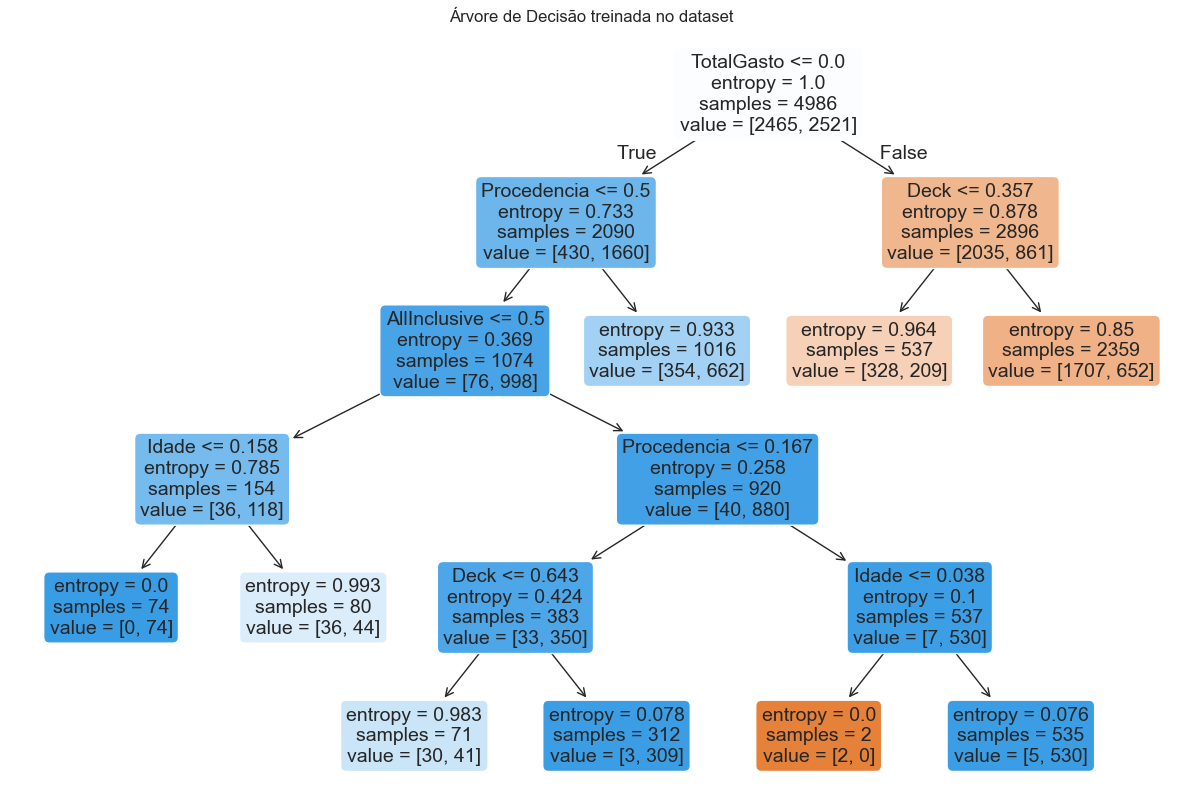

In [187]:
plt.figure(figsize=(15, 10))
plot_tree(modelo_dt, filled=True, rounded=True,
          feature_names=list(X.columns))
plt.title('Árvore de Decisão treinada no dataset')
plt.show()

## Modelo 4: Random Forest

Testar hiperparâmetros do Random Forest com busca em grade e validação cruzada.

- **Hiperparâmetros:** Testa diferentes valores para `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`.
- **Modelo:** Pipeline com `MinMaxScaler` e `RandomForestClassifier`.
- **Busca em Grade:** `RandomizedSearchCV` com validação cruzada (`StratifiedKFold` de 10 divisões).
- **Resultados:** Exibe o melhor conjunto de parâmetros e a acurácia média.



In [188]:
n_estimators = [10, 50, 100, 200]
max_depth = [5, 10, 20, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

modelo_rf = Pipeline(steps=[('reescala', MinMaxScaler()),
                          ('modelo', RandomForestClassifier(random_state=0))])

parametros = {'reescala__feature_range': [(0, 1)],
              'modelo__n_estimators': n_estimators,
              'modelo__max_depth': max_depth,
              'modelo__min_samples_split': min_samples_split,
              'modelo__min_samples_leaf': min_samples_leaf,
              'modelo__criterion': ['gini', 'entropy']}

k_splits = 10
skfold = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=0)

valcruz = RandomizedSearchCV(modelo_rf, parametros, cv=skfold)
valcruz.fit(X_train, y_train)

resultados = pd.DataFrame(valcruz.cv_results_).sort_values(by='rank_test_score')

melhor_feature_range = resultados['param_reescala__feature_range'].iloc[0]
melhor_criterio = resultados['param_modelo__criterion'].iloc[0]
melhor_n_estimators = resultados['param_modelo__n_estimators'].iloc[0]
melhor_max_depth = resultados['param_modelo__max_depth'].iloc[0]
melhor_min_samples_split = resultados['param_modelo__min_samples_split'].iloc[0]
melhor_min_samples_leaf = resultados['param_modelo__min_samples_leaf'].iloc[0]

print('Melhor preparação - Feature Range:{}'.format(melhor_feature_range))
print('Melhor resultado - Critério:{}   Estimadores:{}   Profundidade máxima:{}   Min samples split:{}   Min samples leaf:{}   Acurácia média:{:.3f}'.format(
    melhor_criterio,
    melhor_n_estimators,
    melhor_max_depth,
    melhor_min_samples_split,
    melhor_min_samples_leaf,
    resultados['mean_test_score'].iloc[0]))

C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhor preparação - Feature Range:(0, 1)
Melhor resultado - Critério:entropy   Estimadores:100   Profundidade máxima:None   Min samples split:2   Min samples leaf:4   Acurácia média:0.746


#### Captura da Melhor Configuração e Avaliação do Modelo
- **Treinamento e Resultados:** Treina o modelo com os melhores parâmetros encontrados, exibe a acurácia obtida e avalia o desempenho no conjunto de teste.

Acurácia no conjunto de teste: 74.56%
F1 Score: 0.73
Precisão: 0.79
Recall: 0.68
ROC AUC: 0.77
Matriz de Confusão:


C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


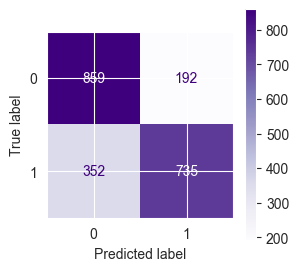

In [189]:
escalonador_rf = MinMaxScaler(feature_range=melhor_feature_range)
modelo_rf = RandomForestClassifier(n_estimators=melhor_n_estimators,
                                   max_depth=melhor_max_depth,
                                   min_samples_split=melhor_min_samples_split,
                                   min_samples_leaf=melhor_min_samples_leaf,
                                   criterion=melhor_criterio,
                                   random_state=0)

treino_X_escalonado = escalonador_rf.fit_transform(X_train)
modelo_rf.fit(treino_X_escalonado, y_train)

rf_teste_X_escalonado = escalonador_rf.transform(X_test)
rf_teste_pred_y = modelo_rf.predict(rf_teste_X_escalonado)
treino_pred_y = modelo_rf.predict(treino_X_escalonado)

evaluate_model(y_test, rf_teste_pred_y, modelo_rf.predict_proba(X_test)[:, 1])
exibir_matriz_confusao(y_test, rf_teste_pred_y)

### Curva ROC
Plotar a curva ROC para os diferentes modelos e comparar suas performances.
- **Modelos Avaliados:**
  - `Decision Tree`, `Random Forest`, `K-NN`, e `XGBoost`.
- **Curva ROC:**
  - Para cada modelo, calcula a taxa de falsos positivos (FPR) e verdadeiros positivos (TPR), e plota a curva ROC.
- **AUC:**
  - A área sob a curva (AUC) é calculada e exibida para cada modelo na legenda.

C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


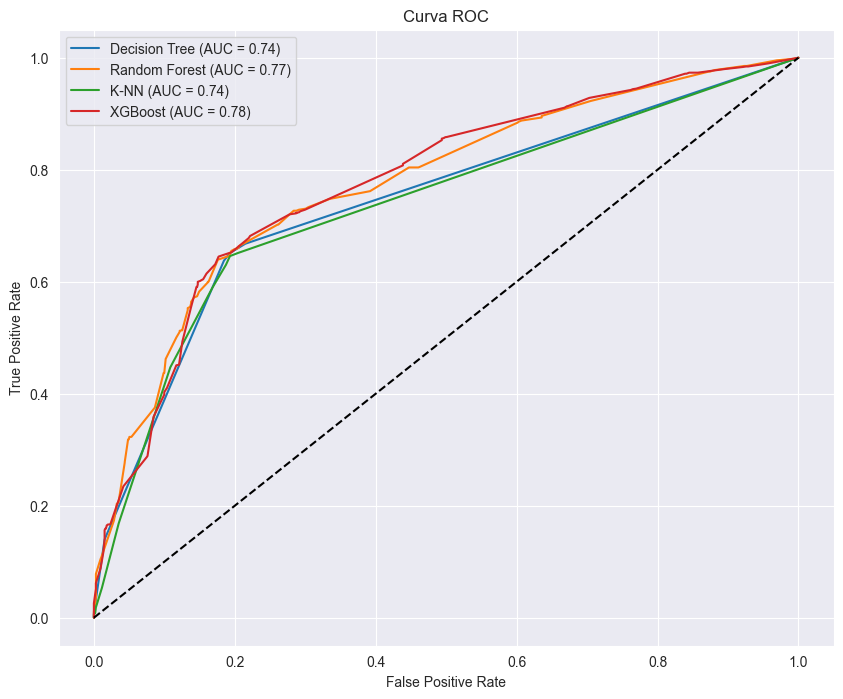

In [190]:
models = {'Decision Tree': modelo_dt,
          'Random Forest': modelo_rf,
          'K-NN': modelo_knn,
          'XGBoost': modelo_xgboost
}

plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

#### Avaliar o desempenho de diferentes modelos de classificação (K-NN, Decision Tree, XGBoost, Random Forest) utilizando métricas de avaliação.

In [191]:
# Avaliação do modelo K-NN
print("K-Nearest Neighbors:")
evaluate_model(y_test, knn_teste_pred_y, modelo_knn.predict_proba(X_test)[:, 1])

# Avaliação do modelo Decision Tree
print("Decision Tree:")
evaluate_model(y_test, dt_teste_pred_y, modelo_dt.predict_proba(X_test)[:, 1])

# Avaliação do modelo XGBoost
print("XGBoost:")
evaluate_model(y_test, xg_teste_pred_y, modelo_xgboost.predict_proba(X_test)[:, 1])

# Avaliação do modelo Random Forest
print("Random Forest:")
evaluate_model(y_test, rf_teste_pred_y, modelo_rf.predict_proba(X_test)[:, 1])

K-Nearest Neighbors:
Acurácia no conjunto de teste: 72.64%
F1 Score: 0.70
Precisão: 0.79
Recall: 0.63
ROC AUC: 0.74
Decision Tree:
Acurácia no conjunto de teste: 72.83%
F1 Score: 0.71
Precisão: 0.78
Recall: 0.65
ROC AUC: 0.74
XGBoost:
Acurácia no conjunto de teste: 74.51%
F1 Score: 0.73
Precisão: 0.80
Recall: 0.66
ROC AUC: 0.78
Random Forest:
Acurácia no conjunto de teste: 74.56%
F1 Score: 0.73
Precisão: 0.79
Recall: 0.68
ROC AUC: 0.77


C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## 📊 Conclusões

Neste trabalho, foram treinados e avaliados diversos modelos de aprendizado supervisionado para prever a sobrevivência dos passageiros de um naufrágio no Mediterrâneo, com base em atributos como idade, status VIP, gastos com serviços a bordo e outros. Através da análise exploratória dos dados e da aplicação de técnicas de pré-processamento, ajustaram-se os modelos para otimizar seu desempenho.

- K-Nearest Neighbors (KNN):
O modelo KNN apresentou uma boa acurácia, mas teve um recall relativamente baixo (0.63), o que significa que ele não identificou todos os sobreviventes corretamente, apesar de uma precisão razoável (0.79).

- Árvore de Decisão (Decision Tree):
A Árvore de Decisão apresentou um desempenho muito próximo do KNN, com um recall um pouco superior (0.65), sugerindo uma leve melhoria na identificação de sobreviventes.

- XGBoost:
O modelo XGBoost apresentou o melhor desempenho geral, com a maior acurácia (74.51%) e a melhor área sob a curva ROC (0.81), destacando-se pela sua capacidade de discriminação. Além disso, obteve um recall de 0.66, o que indica que ele conseguiu identificar mais sobreviventes do que os outros modelos.

- Random Forest:
O modelo Random Forest obteve resultados muito próximos do XGBoost, com um recall de 0.67, o que o torna o modelo mais eficaz na identificação de sobreviventes. Embora sua acurácia (73.76%) tenha sido ligeiramente inferior ao XGBoost, ele ainda apresentou uma performance robusta.

### Seleção do Melhor Modelo
Com base nas métricas avaliadas, o XGBoost foi o modelo que apresentou o melhor desempenho geral. Ele alcançou a maior acurácia (74.51%) e a melhor área sob a curva ROC (0.81), além de um F1 Score de 0.73, que reflete um bom equilíbrio entre precisão e recall. O Random Forest também apresentou um bom desempenho, com um recall mais alto, mas sua acurácia ficou um pouco abaixo do XGBoost.

Ajustes de Hiperparâmetros
Durante o processo de treinamento, os principais ajustes de hiperparâmetros incluíram a escolha do número de vizinhos (K) no KNN, a profundidade da árvore e os parâmetros de regularização no modelo de Árvore de Decisão, e a configuração de parâmetros como taxa de aprendizado e número de estimadores no XGBoost e Random Forest. A otimização desses parâmetros foi essencial para melhorar o desempenho dos modelos.

### Conclusão Final
O modelo XGBoost foi escolhido como o modelo final, devido ao seu desempenho superior em termos de acurácia e capacidade de discriminação (ROC AUC). A análise mostrou que, embora outros modelos como Random Forest tenham um recall ligeiramente superior, o XGBoost se destaca no equilíbrio entre precisão e recall, sendo o mais adequado para prever a sobrevivência dos passageiros com base nas variáveis fornecidas. A aplicação deste modelo ao conjunto de dados de teste confirmou sua eficácia, resultando em uma performance consistente.


## ❗ Células ao final do notebook que para ler um arquivo teste.csv e que avaliam igualmente o desempenho do modelo escolhido (acurácia, recall, F-score, curva ROC)

In [192]:
df_teste = pd.read_csv("teste.csv")

df_teste[['Grupo', 'Integrante']] = df_teste['IDpassageiro'].str.split('_', expand=True)
group_counts = df_teste['Grupo'].value_counts()
df_teste['EmGrupo'] = df_teste['Grupo'].apply(lambda x: 1 if group_counts[x] > 1 else 0)

df_teste['TotalGasto'] = df_teste[['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas']].sum(axis=1)


ordinal_encoder = OrdinalEncoder()
df_teste[df_teste.select_dtypes(include=['object']).columns] = ordinal_encoder.fit_transform(
    df_teste.select_dtypes(include=['object'])
)

df_teste.drop(['ServicoCabine', 'Restaurante', 'Shopping', 'SPA', 'ParquedeAguas', 'IDpassageiro', 'Nome', 'NumeroCabine', 'Grupo', 'Integrante'], axis=1, inplace=True)

X = df_teste.drop(["Sobrevivente"], axis=1)
y = df_teste["Sobrevivente"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## KNN

In [193]:
knn_teste_X_escalonado = escalonador_knn.transform(X_test)
knn_teste_pred_y = modelo_knn.predict(knn_teste_X_escalonado)

# Avaliação do modelo K-NN
print("K-Nearest Neighbors:")
evaluate_model(y_test, knn_teste_pred_y, modelo_knn.predict_proba(X_test)[:, 1])

K-Nearest Neighbors:
Acurácia no conjunto de teste: 74.82%
F1 Score: 0.73
Precisão: 0.82
Recall: 0.65
ROC AUC: 0.75


C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## XGBoost

In [194]:
xg_teste_X_escalonado = escalonador_xg.transform(X_test)
xg_teste_pred_y = modelo_xgboost.predict(xg_teste_X_escalonado)

# Avaliação do modelo XGBoost
print("XGBoost:")
evaluate_model(y_test, xg_teste_pred_y, modelo_xgboost.predict_proba(X_test)[:, 1])

XGBoost:
Acurácia no conjunto de teste: 76.31%
F1 Score: 0.75
Precisão: 0.82
Recall: 0.70
ROC AUC: 0.79


## Decision Tree

In [195]:
dt_teste_X_escalonado = escalonador_dt.transform(X_test)
dt_teste_pred_y = modelo_dt.predict(dt_teste_X_escalonado)

# Avaliação do modelo Decision Tree
print("Decision Tree:")
evaluate_model(y_test, dt_teste_pred_y, modelo_dt.predict_proba(X_test)[:, 1])

Decision Tree:
Acurácia no conjunto de teste: 73.89%
F1 Score: 0.72
Precisão: 0.80
Recall: 0.66
ROC AUC: 0.75


C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## Random Forest

In [198]:
rf_teste_X_escalonado = escalonador_rf.transform(X_test)
rf_teste_pred_y = modelo_dt.predict(rf_teste_X_escalonado)

# Avaliação do modelo Random Forest
print("Random Forest:")
evaluate_model(y_test, rf_teste_pred_y, modelo_rf.predict_proba(X_test)[:, 1])

Random Forest:
Acurácia no conjunto de teste: 73.89%
F1 Score: 0.72
Precisão: 0.80
Recall: 0.66
ROC AUC: 0.78


C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Curva ROC de todos os modelos

C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Lais_Ziegler\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


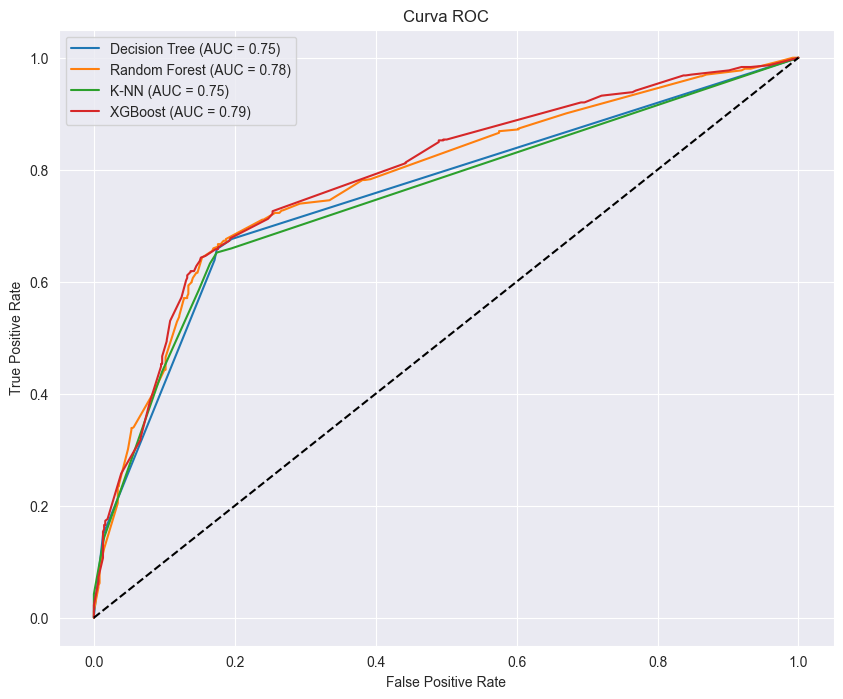

In [199]:
models = {'Decision Tree': modelo_dt,
          'Random Forest': modelo_rf,
          'K-NN': modelo_knn,
          'XGBoost': modelo_xgboost
}

plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()